## <center> Python Geospatial Data Analysis

### <center>By: Mohammed Naji

In [2]:
import folium
import math
from folium.plugins import MarkerCluster,HeatMap
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import datetime
from plotly.subplots import make_subplots

In [3]:
import numpy as np # library to handle data in a vectorized manner
import time
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe


#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
from folium import plugins

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans


We are analysis Boston Crimes, so for that we will use geolocator to find out Boston coordinates

In [5]:
address = 'Boston, Massachusetts, USA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Boston are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Boston are 42.3602534, -71.0582912.


In [6]:
neighborhood_latitude=42.3602534
neighborhood_longitude=-71.0582912


We will use FourSquare API to redrive the spatial information of Boston 

In [7]:
CLIENT_ID = 'MT4MYN0ZDBBWNKBIT2ATB0KPBAVD4IPTGSODCMKDGY44VQRB' 
CLIENT_SECRET = 'ML51XFIPC3A5NT1EKIIBKTSHP3DDJLBMIOIDVENJYMDTII5N' 
VERSION = '20180605' # Foursquare API version


make URL object to make FourSquare API requests using our ID and SECRET

In [8]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=MT4MYN0ZDBBWNKBIT2ATB0KPBAVD4IPTGSODCMKDGY44VQRB&client_secret=ML51XFIPC3A5NT1EKIIBKTSHP3DDJLBMIOIDVENJYMDTII5N&v=20180605&ll=42.3602534,-71.0582912&radius=500&limit=100'

In [9]:
# results display is hidden for report simplification 
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5faeb6ba15cbfb5134cf0eb0'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Downtown Boston',
  'headerFullLocation': 'Downtown Boston, Boston',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 130,
  'suggestedBounds': {'ne': {'lat': 42.3647534045, 'lng': -71.05221261957064},
   'sw': {'lat': 42.355753395499995, 'lng': -71.06436978042936}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '55b95c01498e77bdd5be7a96',
       'name': 'Boston Public Market',
       'location': {'address': '100 Hanover St',
        'crossStreet': 'btwn Sudbury & Congress St',
        'lat': 42.36194982978392,
   

In [12]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [13]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

<ipython-input-13-561c05f0fdd1>:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues) # flatten JSON


,name,categories,lat,lng
0,Boston Public Market,Market,42.361950,-71.057466
1,Faneuil Hall Marketplace,Historic Site,42.359978,-71.056410
2,Saus Restaurant,Belgian Restaurant,42.361076,-71.057054
3,Tatte Bakery & Cafe,Bakery,42.358451,-71.057981
4,Red's Best,Seafood Restaurant,42.361960,-71.057587


In [14]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


Let's draw the map of Boston

In [15]:
Boston = (42.358443, -71.05977)
m = folium.Map(location=Boston, zoom_start=12)
m

We will use Boston crimes dataset which contains the crimes and places that happend in (there is more information in the report file attached with this notebook)

In [16]:
df=pd.read_csv('https://raw.githubusercontent.com/VinitaSilaparasetty/coursera-spatial-data-analysis/master/boston-crime%202.csv')
df.head(10)

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location,Date,Time
0,I192082859,724,Auto Theft,AUTO THEFT,E18,519,NaN,2019-10-13 09:28:24,2019,10,Sunday,9,Part One,LINCOLN ST,42.259518,-71.121563,"(42.25951765, -71.12156299)",2019-10-13,09:28:24
1,I192082751,724,Auto Theft,AUTO THEFT,E18,493,NaN,2019-10-12 20:11:26,2019,10,Saturday,20,Part One,METROPOLITAN AVE,42.262092,-71.116710,"(42.26209214, -71.11670964)",2019-10-12,20:11:26
2,I192082680,727,Auto Theft,AUTO THEFT - LEASED/RENTED VEHICLE,D14,794,NaN,2019-10-12 15:12:43,2019,10,Saturday,15,Part One,ALLSTON ST,42.352375,-71.135096,"(42.35237455, -71.13509584)",2019-10-12,15:12:43
3,I192082577,724,Auto Theft,AUTO THEFT,D4,130,NaN,2019-10-12 04:41:52,2019,10,Saturday,4,Part One,SAINT JAMES AVE,42.349476,-71.076402,"(42.34947586, -71.07640150)",2019-10-12,04:41:52
4,I192079582,727,Auto Theft,AUTO THEFT - LEASED/RENTED VEHICLE,A15,47,NaN,2019-10-02 08:08:49,2019,10,Wednesday,8,Part One,N MEAD ST,42.381846,-71.066551,"(42.38184582, -71.06655134)",2019-10-02,08:08:49
5,I192078648,3114,Investigate Property,INVESTIGATE PROPERTY,B3,427,NaN,2019-09-29 06:39:00,2019,9,Sunday,6,Part Three,WILMORE ST,42.277964,-71.092463,"(42.27796370, -71.09246318)",2019-09-29,06:39:00
6,I192078647,3115,Investigate Person,INVESTIGATE PERSON,A1,,NaN,2019-09-29 03:45:00,2019,9,Sunday,3,Part Three,NASHUA ST,42.367690,-71.065863,"(42.36769032, -71.06586347)",2019-09-29,03:45:00
7,I192078645,3301,Verbal Disputes,VERBAL DISPUTE,B3,450,NaN,2019-09-29 06:00:00,2019,9,Sunday,6,Part Three,ASPINWALL RD,42.291816,-71.072441,"(42.29181580, -71.07244098)",2019-09-29,06:00:00
8,I192078645,1402,Vandalism,VANDALISM,B3,450,NaN,2019-09-29 06:00:00,2019,9,Sunday,6,Part Two,ASPINWALL RD,42.291816,-71.072441,"(42.29181580, -71.07244098)",2019-09-29,06:00:00
9,I192078642,3820,Motor Vehicle Accident Response,M/V ACCIDENT INVOLVING PEDESTRIAN - INJURY,D4,269,NaN,2019-09-29 05:50:00,2019,9,Sunday,5,Part Three,ALBANY ST,42.332419,-71.075013,"(42.33241896, -71.07501315)",2019-09-29,05:50:00


### Mark Crime Scenes

In [17]:
mc = MarkerCluster()
for idx, row in df.iterrows():
    if not math.isnan(row['Long']) and not math.isnan(row['Lat']):
        mc.add_child(folium.Marker([row['Lat'], row['Long']]))
m.add_child(mc)

### View Districts with Highest Crime Rates

In [19]:
crime = df.groupby(['DISTRICT', 'STREET', 'REPORTING_AREA','Lat','Long']).sum().reset_index()

In [20]:
crime.update(crime['DISTRICT'].map('District:{}'.format))
crime.update(crime['REPORTING_AREA'].map('Reports:{}'.format))

### Map of high rate crimes

In [21]:
m2 = folium.Map(location=Boston, tiles ='stamentoner', zoom_start=12)
HeatMap(data=crime[['Lat','Long']], radius=15).add_to(m2)
def plotDot(point):
    folium.CircleMarker(location=[point.Lat,point.Long],
                      radius=5,
                      weght=2,
                      popup=[point.DISTRICT,point.REPORTING_AREA],
                      file_color='#000000').add_to(m2)
crime.apply(plotDot,axis=1)
m2.fit_bounds(m2.get_bounds())
m2

### Medical Assistance Analysis

Now we will analysis places which need medical assistance depending on the type of the crime

In [22]:
med = df.loc[df.OFFENSE_CODE_GROUP=='Medical Assistance'][['Lat','Long']]
med.Lat.fillna(0, inplace=True)
med.Long.fillna(0,inplace=True)
m6 = folium.Map(location=Boston, tiles='openstreetmap', zoom_start=11)
HeatMap(data=med, radius=16).add_to(m6)
m6

### Crimes Commited

By using Seaborn library let's draw a digram of crimes commited

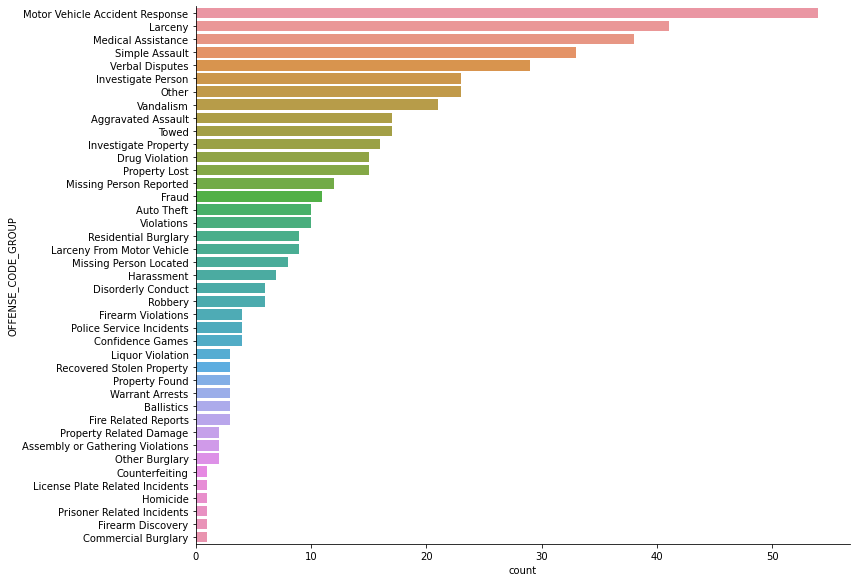

In [23]:
sns.catplot(y='OFFENSE_CODE_GROUP',
           kind='count',
           height=8,
           aspect=1.5,
           order=df.OFFENSE_CODE_GROUP.value_counts().index,
           data=df)

We can see the highest crimes are motor vehicle accidents and larceny. Let's draw a map of each crime and it is locations

### Motor Vehicle Accident Response

In [24]:
mv = df.loc[df.OFFENSE_CODE_GROUP=='Motor Vehicle Accident Response'][['Lat','Long']]
mv.fillna(0, inplace=True)
mv.Lat.fillna(0,inplace=True)
mv.Long.fillna(0, inplace=True)
m4 = folium.Map(location=Boston, tiles='openstreetmap', zoom_start =11)
HeatMap(data=mv,radius=16).add_to(m4)
m4

### Larceny

In [25]:
lar = df.loc[df.OFFENSE_CODE_GROUP=='Larceny'][['Lat','Long']]
lar.Lat.fillna(0,inplace=True)
lar.Long.fillna(0, inplace=True)
m5 = folium.Map(location=Boston, tiles='openstreetmap', zoom_start =11)
HeatMap(data=mv,radius=16).add_to(m5)
m5
